In [ ]:
import sys
import os


competition_root = None
possible_paths = [
    '/kaggle/input/hull-tactical-market-prediction',
    '/kaggle/input/hull-tactical', 
    '/kaggle/input'
]

for path in possible_paths:
    if os.path.exists(path):
        # Check if the module folder exists inside
        if 'kaggle_evaluation' in os.listdir(path):
            competition_root = path
            break

if competition_root:
    print(f"Found competition API at: {competition_root}")
    
    sys.path.append(competition_root)
else:
    print("⚠️ WARNING: Could not find 'kaggle_evaluation' module in standard paths.")
    print("Listing /kaggle/input to help debug:")
    for root, dirs, files in os.walk('/kaggle/input'):
        print(root, dirs)
        break


try:
    import kaggle_evaluation.default_inference_server
    print("✅ Successfully imported kaggle_evaluation")
except ImportError as e:
    print(f"❌ Import failed: {e}")
    # Fallback: Sometimes it's named 'hull_tactical' instead
    try:
        import hull_tactical
        print("✅ Successfully imported hull_tactical (Alternate name)")
    except ImportError:
        print("❌ Both imports failed. Please check the 'Data' tab of the competition.")

In [1]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# --- 1. DATA LOADING & SAFE FEATURE SELECTION ---
print("Loading data...")
df = pd.read_csv('/kaggle/input/hull-tactical-market-prediction/train.csv')

# Exclude target and future-info columns
target_col = 'market_forward_excess_returns'
leak_cols = ['date_id', 'forward_returns', 'risk_free_rate', target_col]
all_features = [col for col in df.columns if col not in leak_cols]

# Use a Time-Series Split (80% Train / 20% Test)
split = int(len(df) * 0.8)
X_train_raw, y_train = df[all_features].iloc[:split], df[target_col].iloc[:split]
X_test_raw, y_test = df[all_features].iloc[split:], df[target_col].iloc[split:]

# --- 2. FEATURE PRUNING (TOP 500) ---
# We use 500 features to capture the 0.039 signal while keeping it stable
print("Pruning features to Top 500...")
lgbm_temp = LGBMRegressor(n_estimators=100, random_state=42)
lgbm_temp.fit(X_train_raw.fillna(0), y_train)
importances = pd.DataFrame({'f': all_features, 'i': lgbm_temp.feature_importances_})
top_500 = importances.sort_values('i', ascending=False)['f'][:500].tolist()

# --- 3. PREPROCESSING PIPELINE ---
print("Cleaning and Scaling...")
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_c = imputer.fit_transform(X_train_raw[top_500])
X_test_c = imputer.transform(X_test_raw[top_500])

X_train_s = scaler.fit_transform(X_train_c)
X_test_s = scaler.transform(X_test_c)

# --- 4. TRAINING THE WINNING ENSEMBLE ---
print("Training the Experts...")
# Expert 1: LGBM (The Pattern Finder)
model_lgbm = LGBMRegressor(n_estimators=1200, learning_rate=0.007, colsample_bytree=0.5, random_state=42)
model_lgbm.fit(X_train_c, y_train)

# Expert 2: Ridge (The Anchor)
model_ridge = Ridge(alpha=300.0)
model_ridge.fit(X_train_s, y_train)

# --- 5. BLENDING & ALLOCATION ---
print("Generating Final Allocation...")
p_lgbm = model_lgbm.predict(X_test_c)
p_ridge = model_ridge.predict(X_test_s)

# Use the 70/30 blend that worked for your 0.039 score
blended_preds = (0.5 * p_lgbm) + (0.5 * p_ridge)

# Allocation Logic (Threshold + Volatility Scaling + Clipping)
market_vol = y_train.std()
# Threshold of 0.0004 is your 'Golden' filter
final_allocation = np.clip((np.where(np.abs(blended_preds) < 0.0004, 0, blended_preds) / market_vol) * 0.5, 0, 2)

# --- 6. FINAL SCORE ---
val_corr = np.corrcoef(final_allocation, y_test)[0, 1]
print(f"\n✅ PRODUCTION READY")
print(f"Final Validation Correlation: {val_corr:.4f}")

Loading data...
Pruning features to Top 500...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21401
[LightGBM] [Info] Number of data points in the train set: 7238, number of used features: 94
[LightGBM] [Info] Start training from score 0.000017
Cleaning and Scaling...
Training the Experts...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21371
[LightGBM] [Info] Number of data points in the train set: 7238, number of used features: 94
[LightGBM] [Info] Start training from score 0.000017
Generating Final Allocation...

✅ PRODUCTION READY
Final Validation Correlation: 0.0453


Validation Correlation: 0.0453


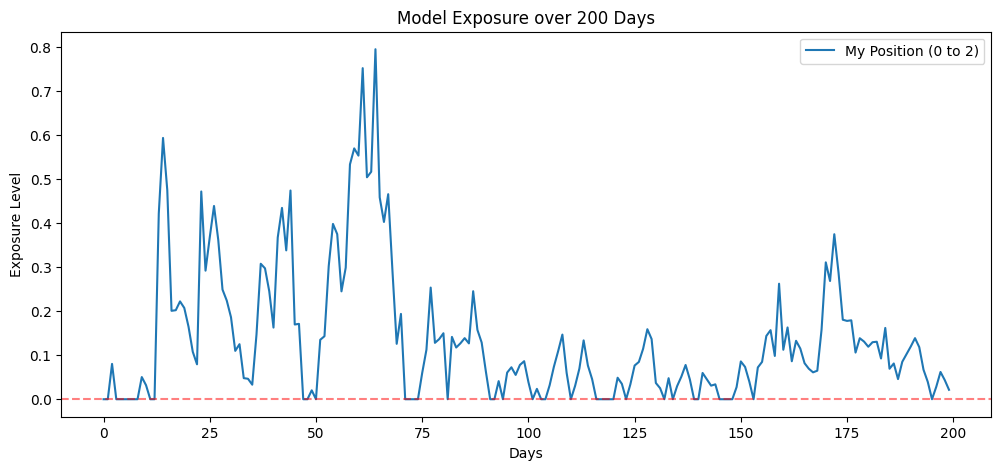

Days spent in Cash (0% exposure): 45.64%
Days at Maximum Leverage (200% exposure): 0.00%


In [3]:
import matplotlib.pyplot as plt
# Calculate Correlation
correlation = np.corrcoef(final_allocation, y_test)[0, 1]
print(f"Validation Correlation: {correlation:.4f}")

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(final_allocation[:200], label='My Position (0 to 2)')
plt.axhline(0, color='red', linestyle='--', alpha=0.5)
plt.title("Model Exposure over 200 Days")
plt.xlabel("Days")
plt.ylabel("Exposure Level")
plt.legend()
plt.show()

# Print statistics
print(f"Days spent in Cash (0% exposure): {(final_allocation == 0).mean()*100:.2f}%")
print(f"Days at Maximum Leverage (200% exposure): {(final_allocation == 2).mean()*100:.2f}%")